In [39]:
import os
import warnings
import logging
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import csv
from torchvision.datasets import ImageFolder
from torchvision import datasets
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns
import shutil
from sklearn.metrics.pairwise import cosine_similarity




warnings.filterwarnings("ignore")

## Data Pre-processing

In [40]:
# Paths to the dataset folders
dataset_paths = {
    "spiralFracture": "Bone_Break_Classifier/SpiralFracture/",
    "PathologicalFracture": "Bone_Break_Classifier/PathologicalFracture/",
    "ObliqueFracture": "Bone_Break_Classifier/ObliqueFracture/",
    "LongitudinalFracture": "Bone_Break_Classifier/LongitudinalFracture/",
    "IntraArticularFracture": "Bone_Break_Classifier/IntraArticularFracture/",
    "ImpactedFracture": "Bone_Break_Classifier/ImpactedFracture/",
    "HairlineFracture": "Bone_Break_Classifier/HairlineFracture/",
    "GreenstickFracture": "Bone_Break_Classifier/GreenstickFracture/",
    "DislocationFracture": "Bone_Break_Classifier/DislocationFracture/",
    "CompressionCrushFracture": "Bone_Break_Classifier/CompressionCrushFracture/",
    "ComminutedFracture": "Bone_Break_Classifier/ComminutedFracture/",
    "AvulsionFracture": "Bone_Break_Classifier/AvulsionFracture/"
}

In [41]:
# Analyzing dataset
image_count = {}
image_formats = Counter()

for class_name, path in dataset_paths.items():
    images = os.listdir(path)
    image_count[class_name] = len(images)
    for img in images:
        image_formats[img.split('.')[-1].lower()] += 1

print("Image Count per Class:")
image_count

Image Count per Class:


{'spiralFracture': 87,
 'PathologicalFracture': 110,
 'ObliqueFracture': 80,
 'LongitudinalFracture': 73,
 'IntraArticularFracture': 87,
 'ImpactedFracture': 89,
 'HairlineFracture': 125,
 'GreenstickFracture': 114,
 'DislocationFracture': 130,
 'CompressionCrushFracture': 120,
 'ComminutedFracture': 147,
 'AvulsionFracture': 122}

In [42]:
print("Image Formats:")
image_formats

Image Formats:


Counter({'jpg': 800, 'jpeg': 317, 'png': 140, 'gif': 26, 'webp': 1})

In [43]:
# Remove files with extension .gif and .webp
def remove_files_with_extension(path, extensions):
    for filename in os.listdir(path):
        if filename.lower().endswith(extensions):
            os.remove(os.path.join(path, filename))
            print(f"Removed: {filename}")
extensions_to_remove = ('.gif', '.webp')

# Iterating over each class directory and remove files with unnecessary extensions
for class_name, path in dataset_paths.items():
    print(f"Cleaning up class: {class_name}")
    remove_files_with_extension(path, extensions_to_remove)

Cleaning up class: spiralFracture
Cleaning up class: PathologicalFracture
Removed: figure1.gif
Removed: figure2.gif
Cleaning up class: ObliqueFracture
Removed: Foot-Series.gif
Cleaning up class: LongitudinalFracture
Removed: C4-FF2-6.gif
Removed: fracture-complete.gif
Removed: radiol.16142305.fig3.gif
Removed: rg.2020190085.fig9.gif
Cleaning up class: IntraArticularFracture
Removed: 12245_2015_75_Fig5_HTML.gif
Removed: rg.2016150216.fig27b.gif
Removed: Xray20-20Lat20-20Smith20Fx_moved.gif
Cleaning up class: ImpactedFracture
Cleaning up class: HairlineFracture
Removed: 13244_2014_371_Fig1_HTML.gif
Removed: rg.2018180073.fig10a.gif
Removed: rg.2018180073.fig4c.gif
Removed: rg.2018180073.fig4d.gif
Removed: rg.2018180073.fig6a.gif
Removed: rg.2018180073.fig9.gif
Cleaning up class: GreenstickFracture
Removed: A214966_1_En_4_Fig3b_HTML.gif
Removed: buckle-fx-distal-radius.gif
Removed: greenstick__distal__fibula..gif
Removed: rg.342135073.fig4.gif
Cleaning up class: DislocationFracture
Remove

In [44]:
# Function to calculate color count in an image
def get_color_count(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    colors = img.getcolors(maxcolors=256**3)  
    return len(colors)

# Function to display images
def display_images(image_paths):
    for image_path in image_paths:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.show()

In [45]:
# Pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained='imagenet')
model.eval()

data_list = []

for class_name, path in tqdm(dataset_paths.items()):
    images = os.listdir(path)
    
    for img_name in images:
        img_path = os.path.join(path, img_name)
        
        # Load and preprocess image
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std_dev of RGB
        ])
        image = preprocess(image)
        image = image.unsqueeze(0)

        # Extract embeddings
        with torch.no_grad():
            embeddings = model(image)

            # Create a dictionary with embeddings, class, and path
            row_data = {f"embedding_{i+1}": value.item() for i, value in enumerate(embeddings[0])}
            row_data['class'] = class_name
            row_data['path'] = img_path
            data_list.append(row_data)

# Create a DataFrame from the list of dictionaries
workingDF = pd.DataFrame(data_list)
workingDF

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:18<00:00, 11.50s/it]


embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       -3.378522     1.284846     0.043607     1.260554     3.479605   
1       -1.848094     2.978379     1.532953     2.569057     5.004469   
2       -3.809473    -3.904888    -1.765737    -3.538975     0.886887   
3       -3.789466    -3.912750    -3.969476    -3.319884     1.116871   
4       -1.938522    -0.330303     3.573163     3.438416     5.139499   
...           ...          ...          ...          ...          ...   
1252    -0.149328     1.419265     0.645460     0.597279     1.304086   
1253     1.276412     1.960133    -0.877962    -1.277206    -2.036461   
1254    -0.899119     1.640448    -0.671237    -0.113375    -0.290816   
1255    -3.132690     2.122205    -0.890480     1.972687     4.160993   
1256     0.607556     3.220061    -0.110223     2.680245     2.715802   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
0       -0.641878    -1.046391    -3.411231    -4.488148     -1.506540  ...   
1        1.509881     1.410589    -3.089261    -3.353636     -0.893992  ...   
2        1.455120    -1.353186    -1.038394    -1.031934      4.861129  ...   
3       -3.259336    -3.546653    -5.174270    -5.597462      0.843182  ...   
4       -0.145623    -0.355042    -1.553579    -1.083597     -1.452551  ...   
...           ...          ...          ...          ...           ...  ...   
1252     0.029629    -0.428928    -1.263488    -0.982731     -1.191742  ...   
1253    -3.765629    -4.224618     0.192033    -0.741056     -3.541726  ...   
1254    -2.476225    -2.024171     0.225797    -0.526004     -1.215230  ...   
1255    -1.473390    -0.468572    -1.053534    -3.166303     -1.076007  ...   
1256     2.929721     0.002016    -3.561948    -4.846962     -4.598604  ...   

      embedding_993  embedding_994  embedding_995  embedding_996  \
0         -3.917672      -5.113196      -4.443556       0.620382   
1         -1.245966      -3.117924      -1.481201       1.368065   
2         -2.666069      -0.885523      -0.489107      -2.222746   
3         -3.696393      -1.895071       0.191601      -2.142022   
4         -6.481277      -6.398779      -1.660001      -4.241234   
...             ...            ...            ...            ...   
1252      -1.280514      -2.022980      -2.498964      -0.481475   
1253      -2.849321      -3.938137      -1.305279      -1.626999   
1254      -1.565436      -5.203130      -2.991724      -1.507977   
1255      -3.239553      -5.006283      -6.398017      -3.273866   
1256      -2.851807      -0.197106       0.842477       0.130532   

      embedding_997  embedding_998  embedding_999  embedding_1000  \
0         -1.740096      -3.785853       0.998965        2.736010   
1          0.150323      -3.330071       3.124024        4.390635   
2         -0.950555      -3.858117       0.652780        1.931750   
3         -0.540787      -7.445231       0.476014        3.149789   
4         -4.163421      -5.089740       1.737933        7.669780   
...             ...            ...            ...             ...   
1252       0.288701      -3.391221      -1.704050        2.342594   
1253      -0.299629      -3.979919       1.550607        2.024171   
1254      -1.074937      -1.981432       1.929319        3.820926   
1255      -1.869247      -4.927500       1.090722        2.114085   
1256       1.110834      -4.682260       1.055729        2.867413   

                 class                                               path  
0       spiralFracture  Bone_Break_Classifier/SpiralFracture/0._jumbo....  
1       spiralFracture  Bone_Break_Classifier/SpiralFracture/110001_ju...  
2       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
3       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
4       spiralFracture  Bone_Break_Classifier/SpiralFracture/192811243...  
...                ...                                                ...  
12

In [46]:
# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(workingDF.iloc[:, :-2])

# List to store duplicate pairs
duplicates = []

# Set cosine similarity threshold
cosine_threshold = 0.85

# Find duplicate pairs
for i in range(len(workingDF)):
    for j in range(i + 1, len(workingDF)):
        if 0.95 > similarity_matrix[i, j] > cosine_threshold:
            duplicates.append((i, j))

# Display duplicate pairs
for i, j in duplicates:
    if i != j:
        print(workingDF.loc[i, 'path'].split(os.path.sep)[-2:], ' similar to ',  workingDF.loc[j, 'path'].split(os.path.sep)[-2:])

['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/SpiralFracture/110001_jumbo.jpeg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/LongitudinalFracture/110002_gallery.jpeg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/GreenstickFracture/3115574c112e21d961cf0f63929a8786.jpg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/GreenstickFracture/Greenstickfx.jpg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/GreenstickFracture/torus20fx.jpg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/DislocationFracture/847b5a158bed0311bf28b5cd647088_jumbo.jpg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jpeg']  similar to  ['Bone_Break_Classifier/ComminutedFracture/images16.jpg']
['Bone_Break_Classifier/SpiralFracture/0._jumbo.jp

In [47]:
# Iterate over duplicate pairs
class_mean_embeddings = {}
# List to store removed paths
removed_paths = []

# Iterate over duplicate pairs
for i, j in duplicates:
    try:
        path_i = workingDF.loc[i, 'path']
        path_j = workingDF.loc[j, 'path']

        # Check if the files exist before processing
        if os.path.exists(path_i) and os.path.exists(path_j):
            embedding_i = workingDF.loc[i, workingDF.columns[:-2]].values
            class_i = workingDF.loc[i, 'class']
            class_j = workingDF.loc[j, 'class']

            # Check if classes are the same
            if class_i == class_j:
                size_i = os.path.getsize(path_i)
                size_j = os.path.getsize(path_j)
                if size_j < size_i:
                    removed_paths.append(path_j)
                    os.remove(path_j)
                else:
                    removed_paths.append(path_i)
                    os.remove(path_i)
            else:
                # Check if mean embeddings exist for both classes
                if class_i in class_mean_embeddings and class_j in class_mean_embeddings:
                    distance_ii = cosine(embedding_i, class_mean_embeddings[class_i])
                    distance_ij = cosine(embedding_i, class_mean_embeddings[class_j])

                    # Compare distances and remove the image with the larger distance
                    if distance_ii < distance_ij:
                        # Print file paths before attempting to remove
                        if os.path.exists(path_j):
                            removed_paths.append(path_j)
                            os.remove(path_j)
                    else:
                        removed_paths.append(path_i)
                        os.remove(path_i)
    except Exception as e:
        print(f"An error occurred: {e}")

# List to store duplicate pairs
duplicate_confirm = []

# Set cosine similarity threshold
cosine_threshold = 0.85

# Find duplicate pairs
for i in range(len(workingDF)):
    for j in range(i + 1, len(workingDF)):
        if 0.95 > similarity_matrix[i, j] > cosine_threshold:
            duplicate_confirm.append((i, j))

# Check if there are no duplicates
if not duplicate_confirm:
    print("Duplication handled.")
else:
    print("Duplication handled. No specific pairs shown.")

Duplication handled. No specific pairs shown.


In [48]:
# Filter out rows where the image file does not exist
workingDF = workingDF[workingDF['path'].apply(lambda x: os.path.exists(x))]
workingDF

embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       -3.378522     1.284846     0.043607     1.260554     3.479605   
2       -3.809473    -3.904888    -1.765737    -3.538975     0.886887   
3       -3.789466    -3.912750    -3.969476    -3.319884     1.116871   
4       -1.938522    -0.330303     3.573163     3.438416     5.139499   
5       -2.386643     1.681097    -2.603540    -0.959443     0.208065   
...           ...          ...          ...          ...          ...   
1251    -2.982049    -0.308437    -0.680577    -0.131363    -1.129379   
1252    -0.149328     1.419265     0.645460     0.597279     1.304086   
1253     1.276412     1.960133    -0.877962    -1.277206    -2.036461   
1254    -0.899119     1.640448    -0.671237    -0.113375    -0.290816   
1256     0.607556     3.220061    -0.110223     2.680245     2.715802   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
0       -0.641878    -1.046391    -3.411231    -4.488148     -1.506540  ...   
2        1.455120    -1.353186    -1.038394    -1.031934      4.861129  ...   
3       -3.259336    -3.546653    -5.174270    -5.597462      0.843182  ...   
4       -0.145623    -0.355042    -1.553579    -1.083597     -1.452551  ...   
5       -4.907642    -4.415678     0.245913    -2.141329      2.018209  ...   
...           ...          ...          ...          ...           ...  ...   
1251    -3.232437    -1.782922    -2.182091    -3.599405      0.351833  ...   
1252     0.029629    -0.428928    -1.263488    -0.982731     -1.191742  ...   
1253    -3.765629    -4.224618     0.192033    -0.741056     -3.541726  ...   
1254    -2.476225    -2.024171     0.225797    -0.526004     -1.215230  ...   
1256     2.929721     0.002016    -3.561948    -4.846962     -4.598604  ...   

      embedding_993  embedding_994  embedding_995  embedding_996  \
0         -3.917672      -5.113196      -4.443556       0.620382   
2         -2.666069      -0.885523      -0.489107      -2.222746   
3         -3.696393      -1.895071       0.191601      -2.142022   
4         -6.481277      -6.398779      -1.660001      -4.241234   
5         -3.580917      -6.047525      -5.063119      -4.961215   
...             ...            ...            ...            ...   
1251      -4.778244      -6.322385      -3.133709      -3.320552   
1252      -1.280514      -2.022980      -2.498964      -0.481475   
1253      -2.849321      -3.938137      -1.305279      -1.626999   
1254      -1.565436      -5.203130      -2.991724      -1.507977   
1256      -2.851807      -0.197106       0.842477       0.130532   

      embedding_997  embedding_998  embedding_999  embedding_1000  \
0         -1.740096      -3.785853       0.998965        2.736010   
2         -0.950555      -3.858117       0.652780        1.931750   
3         -0.540787      -7.445231       0.476014        3.149789   
4         -4.163421      -5.089740       1.737933        7.669780   
5         -4.029475      -5.798604      -0.054667        2.695444   
...             ...            ...            ...             ...   
1251      -4.036597      -6.223440       2.230039        4.297155   
1252       0.288701      -3.391221      -1.704050        2.342594   
1253      -0.299629      -3.979919       1.550607        2.024171   
1254      -1.074937      -1.981432       1.929319        3.820926   
1256       1.110834      -4.682260       1.055729        2.867413   

                 class                                               path  
0       spiralFracture  Bone_Break_Classifier/SpiralFracture/0._jumbo....  
2       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
3       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
4       spiralFracture  Bone_Break_Classifier/SpiralFracture/192811243...  
5       spiralFracture  Bone_Break_Classifier/SpiralFracture/247_2019_...  
...                ...                                                ...  
12

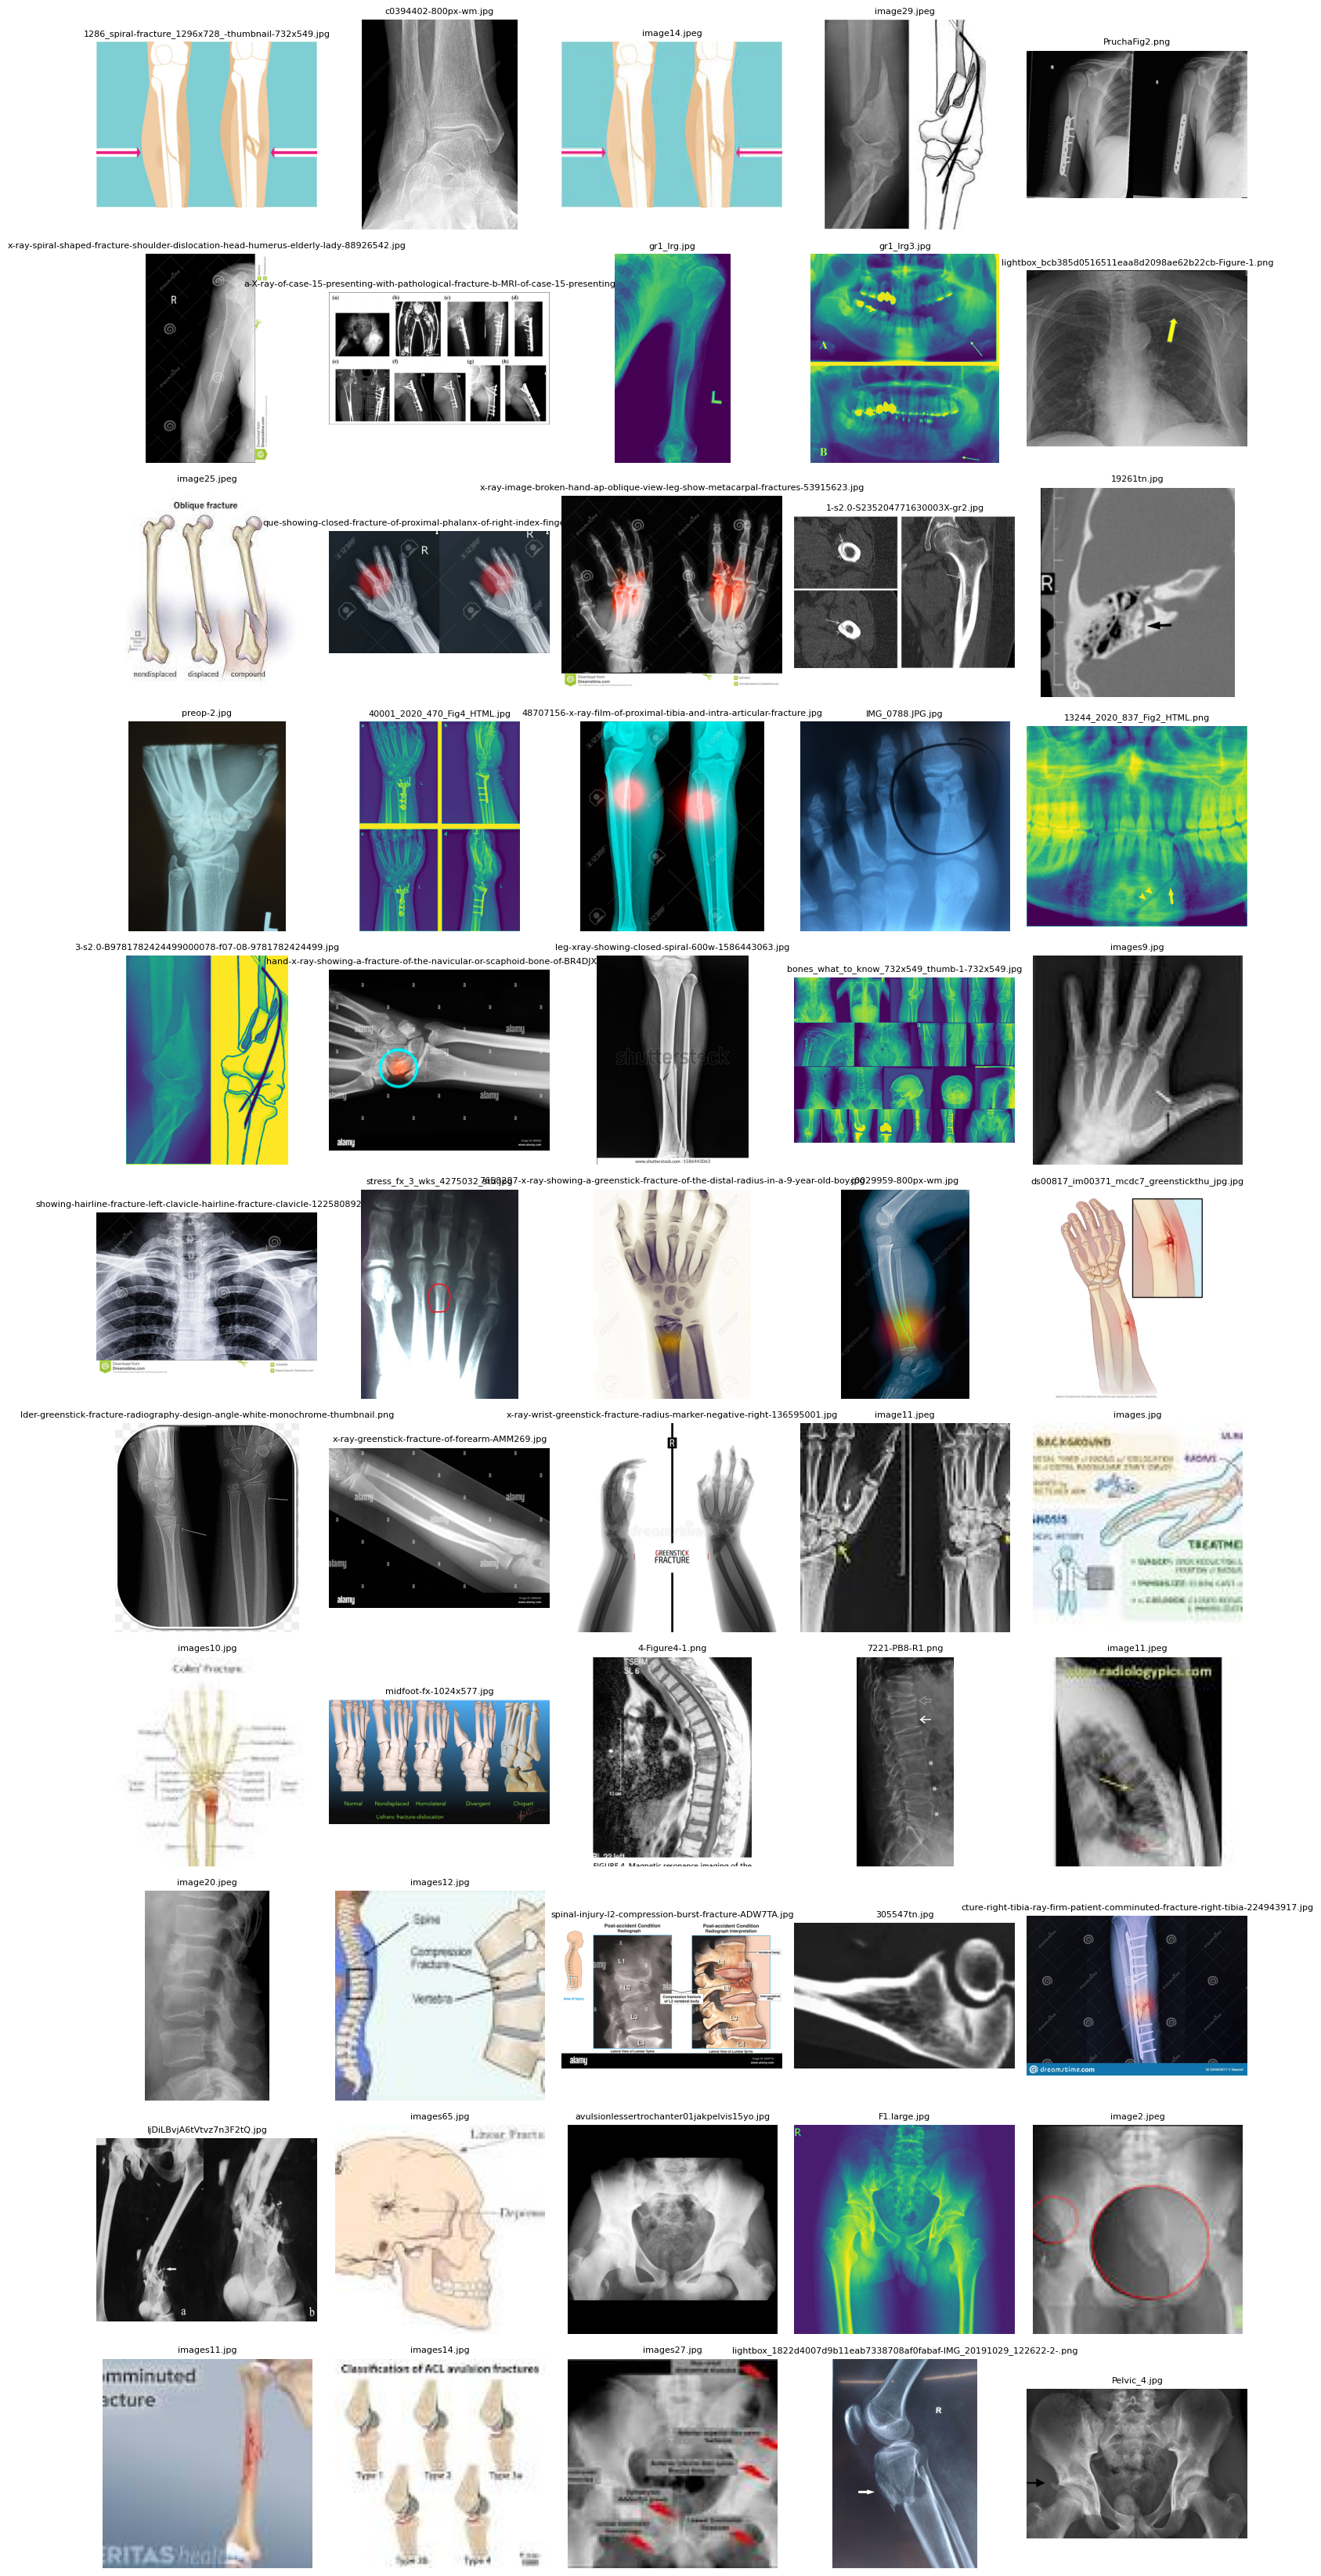

In [49]:
# PCA for dimensionality reduction
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(workingDF.iloc[:, :-2])

# Using Isolation Forest for outlier detection
from sklearn.ensemble import IsolationForest

# Using Isolation Forest for outlier detection
isolation_forest = IsolationForest(contamination=0.05)  
outliers = isolation_forest.fit_predict(reduced_embeddings)

# Add outlier information to the DataFrame
workingDF['outlier'] = outliers

# Filter out the outlier images
outlier_images = workingDF[workingDF['outlier'] == -1]['path'].tolist()
def display_images_in_grid_with_paths(image_paths, columns=5):
    if not image_paths:
        print("No images to display.")
        return

    rows = len(image_paths) // columns 
    rows += 0 if len(image_paths) % columns == 0 else 1

    fig, axs = plt.subplots(rows, columns, figsize=(15, rows * 3)) 
    axs = axs.ravel()

    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        axs[idx].imshow(img)
        axs[idx].set_axis_off()
        axs[idx].set_title(os.path.basename(img_path), fontsize=8)  # Display image path

    for ax in axs[len(image_paths):]:
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Display the outlier images
display_images_in_grid_with_paths(outlier_images)

In [50]:
# Flag the outliers in the DataFrame
workingDF['is_outlier'] = workingDF['outlier'] == -1

# Create a new DataFrame without the outliers
workingDF_clean = workingDF[~workingDF['is_outlier']].drop(columns=['outlier', 'is_outlier'])

# reset the index of the new DataFrame
workingDF_clean.reset_index(drop=True, inplace=True)
workingDF_clean

embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       -3.378522     1.284846     0.043607     1.260554     3.479605   
1       -3.809473    -3.904888    -1.765737    -3.538975     0.886887   
2       -1.938522    -0.330303     3.573163     3.438416     5.139499   
3       -2.386643     1.681097    -2.603540    -0.959443     0.208065   
4        1.426746     1.472805     1.041018     1.682961     1.283141   
...           ...          ...          ...          ...          ...   
1024    -2.982049    -0.308437    -0.680577    -0.131363    -1.129379   
1025    -0.149328     1.419265     0.645460     0.597279     1.304086   
1026     1.276412     1.960133    -0.877962    -1.277206    -2.036461   
1027    -0.899119     1.640448    -0.671237    -0.113375    -0.290816   
1028     0.607556     3.220061    -0.110223     2.680245     2.715802   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
0       -0.641878    -1.046391    -3.411231    -4.488148     -1.506540  ...   
1        1.455120    -1.353186    -1.038394    -1.031934      4.861129  ...   
2       -0.145623    -0.355042    -1.553579    -1.083597     -1.452551  ...   
3       -4.907642    -4.415678     0.245913    -2.141329      2.018209  ...   
4       -2.261375    -2.963046    -2.435654    -4.025161     -3.618086  ...   
...           ...          ...          ...          ...           ...  ...   
1024    -3.232437    -1.782922    -2.182091    -3.599405      0.351833  ...   
1025     0.029629    -0.428928    -1.263488    -0.982731     -1.191742  ...   
1026    -3.765629    -4.224618     0.192033    -0.741056     -3.541726  ...   
1027    -2.476225    -2.024171     0.225797    -0.526004     -1.215230  ...   
1028     2.929721     0.002016    -3.561948    -4.846962     -4.598604  ...   

      embedding_993  embedding_994  embedding_995  embedding_996  \
0         -3.917672      -5.113196      -4.443556       0.620382   
1         -2.666069      -0.885523      -0.489107      -2.222746   
2         -6.481277      -6.398779      -1.660001      -4.241234   
3         -3.580917      -6.047525      -5.063119      -4.961215   
4         -5.830502      -5.797846      -1.947994      -3.803274   
...             ...            ...            ...            ...   
1024      -4.778244      -6.322385      -3.133709      -3.320552   
1025      -1.280514      -2.022980      -2.498964      -0.481475   
1026      -2.849321      -3.938137      -1.305279      -1.626999   
1027      -1.565436      -5.203130      -2.991724      -1.507977   
1028      -2.851807      -0.197106       0.842477       0.130532   

      embedding_997  embedding_998  embedding_999  embedding_1000  \
0         -1.740096      -3.785853       0.998965        2.736010   
1         -0.950555      -3.858117       0.652780        1.931750   
2         -4.163421      -5.089740       1.737933        7.669780   
3         -4.029475      -5.798604      -0.054667        2.695444   
4         -1.738973      -3.582298       4.013497        2.870834   
...             ...            ...            ...             ...   
1024      -4.036597      -6.223440       2.230039        4.297155   
1025       0.288701      -3.391221      -1.704050        2.342594   
1026      -0.299629      -3.979919       1.550607        2.024171   
1027      -1.074937      -1.981432       1.929319        3.820926   
1028       1.110834      -4.682260       1.055729        2.867413   

                 class                                               path  
0       spiralFracture  Bone_Break_Classifier/SpiralFracture/0._jumbo....  
1       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
2       spiralFracture  Bone_Break_Classifier/SpiralFracture/192811243...  
3       spiralFracture  Bone_Break_Classifier/SpiralFracture/247_2019_...  
4       spiralFracture  Bone_Break_Classifier/SpiralFracture/3-s2.0-B9...  
...                ...                                                ...  
10

In [51]:
import csv
unique_classes = workingDF_clean['class'].unique()
# Iterate over unique classes
for class_ in unique_classes:
    class_df = workingDF_clean[workingDF_clean['class'] == class_]
    
    # Calculate mean embedding for the class
    mean_embedding = np.mean(class_df.iloc[:, :-3].values, axis=0)
    class_mean_embeddings[class_] = mean_embedding

# Set a threshold for considering an image as irrelevant
distance_threshold = 0.5  # I run this code several time to use threshold distance of 0.2, 0.3, 0.4, and 0.5

# List to store potentially irrelevant images
potential_irrelevant_images = []

# Iterate over all images
for i in range(len(workingDF_clean)):
    try:
        embedding_i = workingDF_clean.loc[i, workingDF_clean.columns[:-3]].values
        class_i = workingDF_clean.loc[i, 'class']
        
        # Calculate the distance between the image's mean embedding and the class mean embedding
        distance_to_class_mean = cosine(embedding_i, class_mean_embeddings[class_i])
        
        # Compare with the threshold
        if distance_to_class_mean > distance_threshold:
            # Store the potentially irrelevant image
            potential_irrelevant_images.append(workingDF_clean.loc[i, 'path'])
    except Exception as e:
         print(f"An error occurred at index {i}: {type(e).__name__}, {str(e)}")

# Write potentially irrelevant images to a CSV file 
csv_file_path = 'potential_irrelevant.csv'
with open(csv_file_path, 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    if csvfile.tell() == 0:
        csv_writer.writerow(['Path'])
    
    # Write potentially irrelevant images
    csv_writer.writerows([[image_path] for image_path in potential_irrelevant_images])

print(f"Potentially irrelevant images appended to {csv_file_path}")

Potentially irrelevant images appended to potential_irrelevant.csv


In [52]:
# Check the potential irrelevant csv file
PI = csv_file_path
irrelevantsall = pd.read_csv(PI)
irrelevantsall

Path
0     Bone_Break_Classifier/SpiralFracture/1286_spir...
1     Bone_Break_Classifier/SpiralFracture/1286_spir...
2     Bone_Break_Classifier/SpiralFracture/247_2019_...
3     Bone_Break_Classifier/SpiralFracture/3-s2.0-B9...
4     Bone_Break_Classifier/SpiralFracture/373296882...
...                                                 ...
1430  Bone_Break_Classifier/CompressionCrushFracture...
1431  Bone_Break_Classifier/CompressionCrushFracture...
1432  Bone_Break_Classifier/CompressionCrushFracture...
1433  Bone_Break_Classifier/CompressionCrushFracture...
1434  Bone_Break_Classifier/ComminutedFracture/image...

[1435 rows x 1 columns]

In [53]:
# Load the CSV file into a DataFrame
irrelevants = pd.read_csv(csv_file_path)

# Find the mode of the 'path' column
mode_paths = irrelevants['Path'].mode()

# Print the frequently occurring paths
print("Frequently occurring paths (mode):")
for path in mode_paths:
    print(path)

Frequently occurring paths (mode):
Bone_Break_Classifier/CompressionCrushFracture/images24.jpg
Bone_Break_Classifier/CompressionCrushFracture/images29.jpg
Bone_Break_Classifier/DislocationFracture/a-Radiograph-showing-the-sacroiliac-fracture-dislocation-with-fractures-of-bilateral.png
Bone_Break_Classifier/DislocationFracture/image4.jpeg
Bone_Break_Classifier/ImpactedFracture/images10.jpg
Bone_Break_Classifier/ObliqueFracture/oblique-view-of-adult-fractured-elbow-ARR2YE.jpg
Bone_Break_Classifier/PathologicalFracture/image4.jpeg
Bone_Break_Classifier/PathologicalFracture/medical-case-reports-cortical-destruction-5-1-108-g003.png


In [54]:
# Remove rows with paths found in mode_paths from the original DataFrame
for path in mode_paths:
    index_to_remove = workingDF_clean[workingDF_clean['path'] == path].index
    workingDF_clean = workingDF_clean.drop(index_to_remove)

# Verify the DataFrame after removal
workingDF_clean.head()

# save the cleaned DataFrame to a new CSV file
workingDF_path = 'BONEBREAK_cleaned_data.csv'
workingDF_clean.to_csv(workingDF_path, index=False)
print(f"Cleaned data saved to {workingDF_path}")

Cleaned data saved to BONEBREAK_cleaned_data.csv


In [55]:
workingDF = pd.read_csv(workingDF_path)
workingDF

embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       -3.378522     1.284846     0.043607     1.260554     3.479605   
1       -3.809473    -3.904888    -1.765737    -3.538975     0.886887   
2       -1.938522    -0.330303     3.573163     3.438416     5.139499   
3       -2.386643     1.681097    -2.603540    -0.959443     0.208065   
4        1.426746     1.472805     1.041018     1.682961     1.283141   
...           ...          ...          ...          ...          ...   
1016    -2.982049    -0.308437    -0.680577    -0.131363    -1.129379   
1017    -0.149328     1.419265     0.645460     0.597279     1.304086   
1018     1.276412     1.960133    -0.877962    -1.277206    -2.036461   
1019    -0.899119     1.640448    -0.671237    -0.113375    -0.290816   
1020     0.607556     3.220061    -0.110223     2.680245     2.715802   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
0       -0.641878    -1.046391    -3.411231    -4.488148     -1.506540  ...   
1        1.455120    -1.353186    -1.038394    -1.031934      4.861129  ...   
2       -0.145623    -0.355042    -1.553579    -1.083597     -1.452551  ...   
3       -4.907642    -4.415678     0.245913    -2.141329      2.018209  ...   
4       -2.261375    -2.963046    -2.435654    -4.025161     -3.618086  ...   
...           ...          ...          ...          ...           ...  ...   
1016    -3.232437    -1.782922    -2.182091    -3.599405      0.351833  ...   
1017     0.029629    -0.428928    -1.263488    -0.982731     -1.191742  ...   
1018    -3.765629    -4.224618     0.192033    -0.741056     -3.541726  ...   
1019    -2.476225    -2.024171     0.225797    -0.526004     -1.215230  ...   
1020     2.929721     0.002016    -3.561948    -4.846962     -4.598604  ...   

      embedding_993  embedding_994  embedding_995  embedding_996  \
0         -3.917672      -5.113196      -4.443556       0.620382   
1         -2.666069      -0.885523      -0.489107      -2.222746   
2         -6.481277      -6.398779      -1.660001      -4.241234   
3         -3.580917      -6.047525      -5.063119      -4.961215   
4         -5.830502      -5.797846      -1.947994      -3.803274   
...             ...            ...            ...            ...   
1016      -4.778244      -6.322385      -3.133709      -3.320552   
1017      -1.280514      -2.022980      -2.498964      -0.481475   
1018      -2.849321      -3.938137      -1.305279      -1.626999   
1019      -1.565436      -5.203130      -2.991724      -1.507977   
1020      -2.851807      -0.197106       0.842477       0.130532   

      embedding_997  embedding_998  embedding_999  embedding_1000  \
0         -1.740096      -3.785853       0.998965        2.736010   
1         -0.950555      -3.858117       0.652780        1.931750   
2         -4.163421      -5.089740       1.737933        7.669780   
3         -4.029475      -5.798604      -0.054667        2.695444   
4         -1.738973      -3.582298       4.013497        2.870834   
...             ...            ...            ...             ...   
1016      -4.036597      -6.223440       2.230039        4.297155   
1017       0.288701      -3.391221      -1.704050        2.342594   
1018      -0.299629      -3.979919       1.550607        2.024171   
1019      -1.074937      -1.981432       1.929319        3.820926   
1020       1.110834      -4.682260       1.055729        2.867413   

                 class                                               path  
0       spiralFracture  Bone_Break_Classifier/SpiralFracture/0._jumbo....  
1       spiralFracture  Bone_Break_Classifier/SpiralFracture/1286_spir...  
2       spiralFracture  Bone_Break_Classifier/SpiralFracture/192811243...  
3       spiralFracture  Bone_Break_Classifier/SpiralFracture/247_2019_...  
4       spiralFracture  Bone_Break_Classifier/SpiralFracture/3-s2.0-B9...  
...                ...                                                ...  
10

## Data Exploration

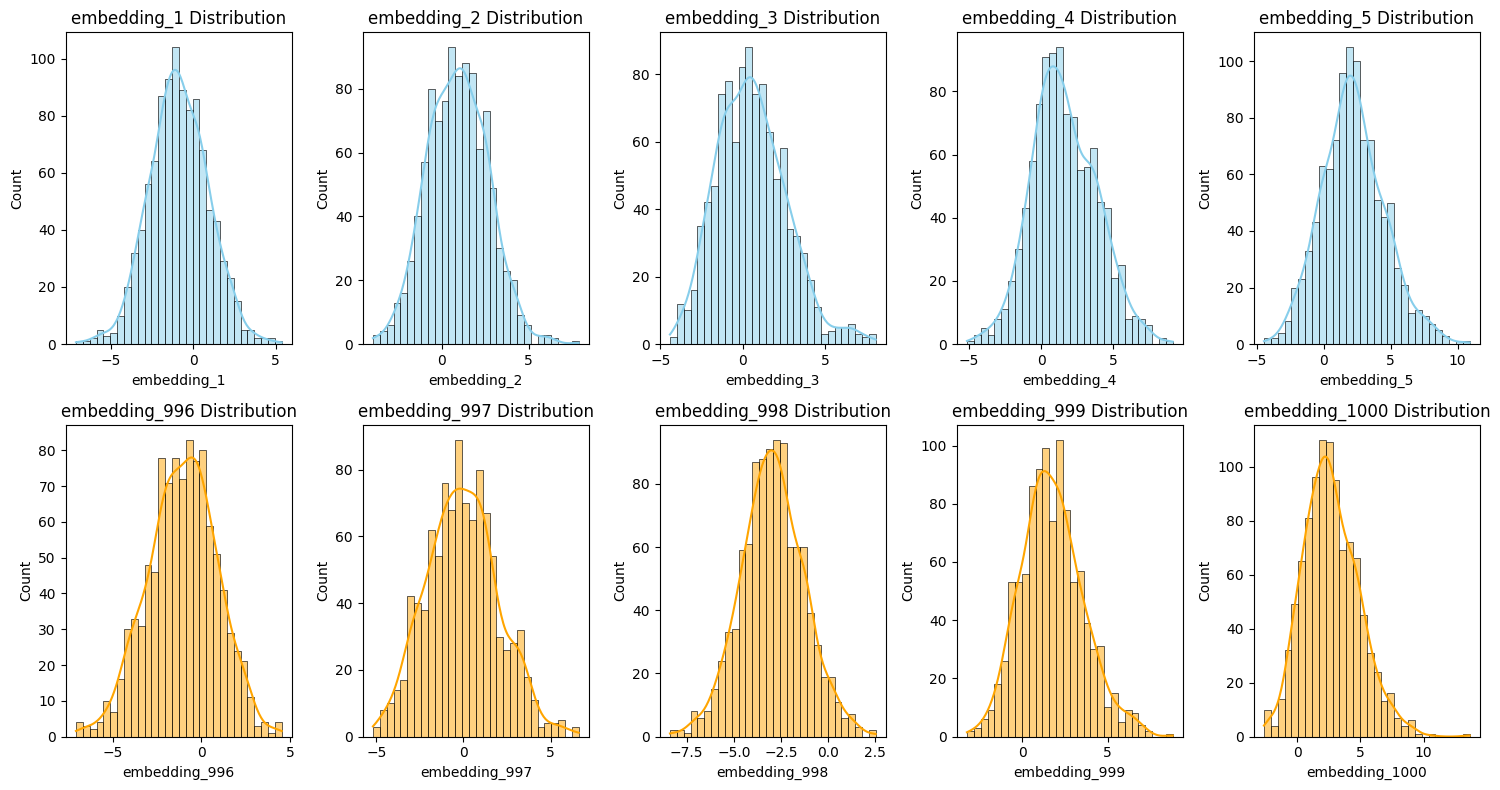

In [56]:
# Visualize the distribution of the first 5 embeddings and the last 5 embeddings
start_embedding = 1
end_embedding = 5

first_five_embeddings = [f'embedding_{i}' for i in range(start_embedding, end_embedding + 1)]

start_embedding = 996
end_embedding = 1000

last_five_embeddings = [f'embedding_{i}' for i in range(start_embedding, end_embedding + 1)]

plt.figure(figsize=(15, 8))

# Plot for the first 5 embeddings
for i, emb in enumerate(first_five_embeddings, 1):
    plt.subplot(2, 5, i)
    sns.histplot(workingDF[emb], kde=True, color='skyblue', bins=30)
    plt.title(f'{emb} Distribution')

# Plot for the last 5 embeddings
for i, emb in enumerate(last_five_embeddings, 1):
    plt.subplot(2, 5, i + 5)  # Start plotting in the second row
    sns.histplot(workingDF[emb], kde=True, color='orange', bins=30)
    plt.title(f'{emb} Distribution')

plt.tight_layout()
plt.show()

## Build Classification Model

In [57]:
# Root dir for the cleaned images
base_dir = 'BoneBreak_Clean'

# Clear out the existing directory to start fresh
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

# Copying images from workingDF_clean
for class_name in workingDF_clean['class'].unique():
    class_dir = os.path.join(base_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    for _, row in workingDF_clean[workingDF_clean['class'] == class_name].iterrows():
        src_path = row['path']
        dst_path = os.path.join(class_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

print("Images have been copied to 'BoneBreak_Clean/'.")

Images have been copied to 'BoneBreak_Clean/'.


In [58]:
# Paths to the cleaned dataset folders
cleaned_dataset_paths = {
    "spiralFracture": "BoneBreak_Clean/SpiralFracture/",
    "PathologicalFracture": "BoneBreak_Clean/PathologicalFracture/",
    "ObliqueFracture": "BoneBreak_Clean/ObliqueFracture/",
    "LongitudinalFracture": "BoneBreak_Clean/LongitudinalFracture/",
    "IntraArticularFracture": "BoneBreak_Clean/IntraArticularFracture/",
    "ImpactedFracture": "BoneBreak_Clean/ImpactedFracture/",
    "HairlineFracture": "BoneBreak_Clean/HairlineFracture/",
    "GreenstickFracture": "BoneBreak_Clean/GreenstickFracture/",
    "DislocationFracture": "BoneBreak_Clean/DislocationFracture/",
    "CompressionCrushFracture": "BoneBreak_Clean/CompressionCrushFracture/",
    "ComminutedFracture": "BoneBreak_Clean/ComminutedFracture/",
    "AvulsionFracture": "BoneBreak_Clean/AvulsionFracture/"
}

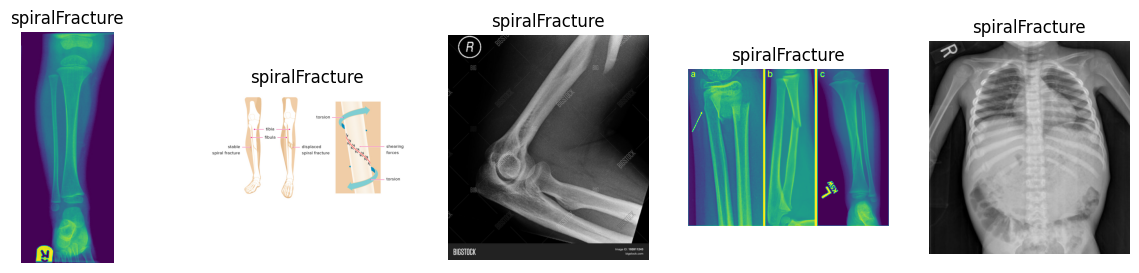

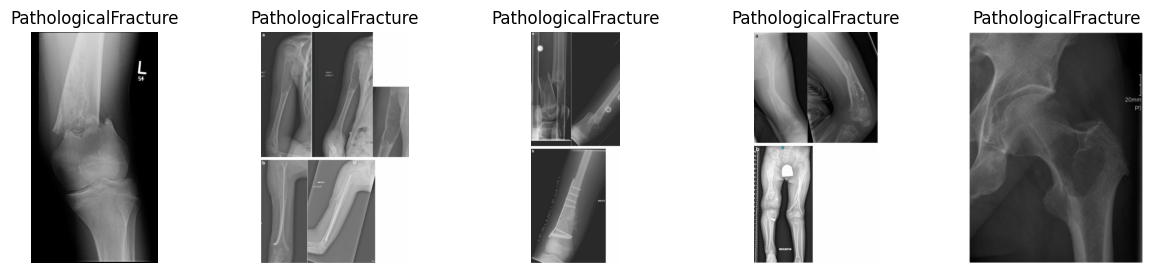

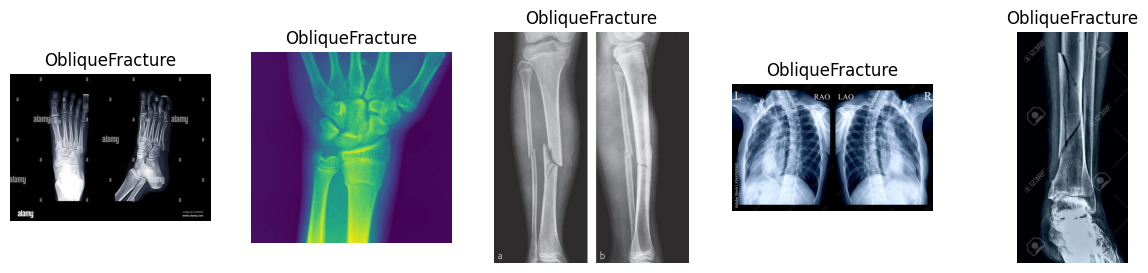

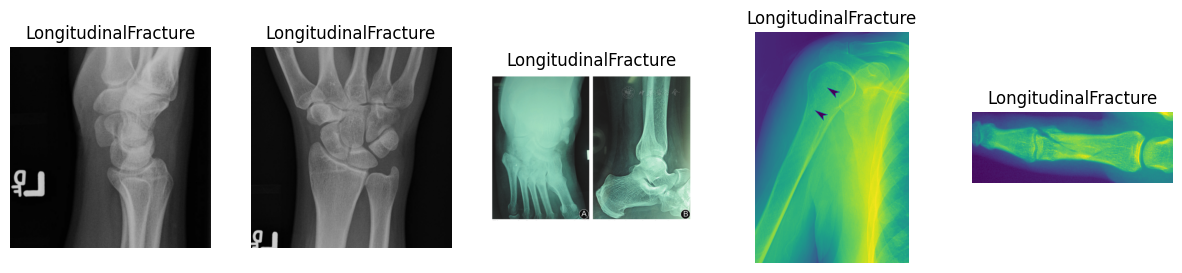

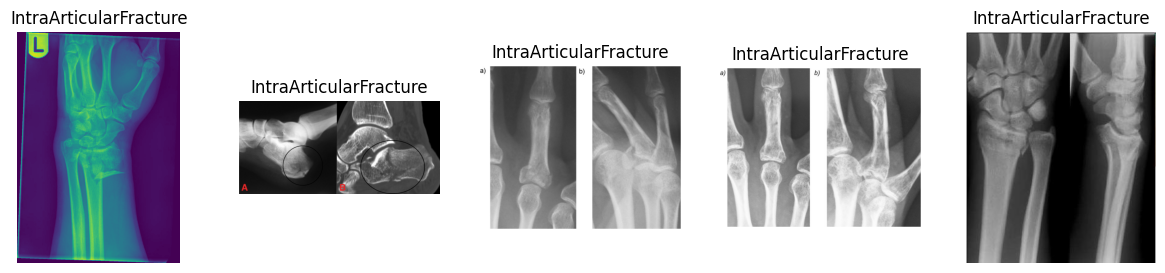

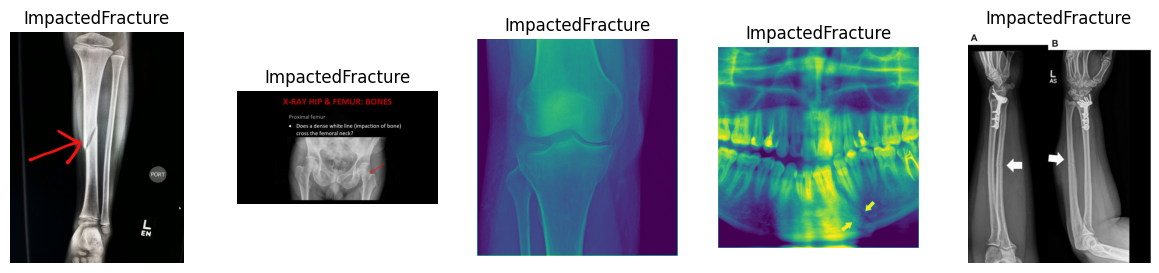

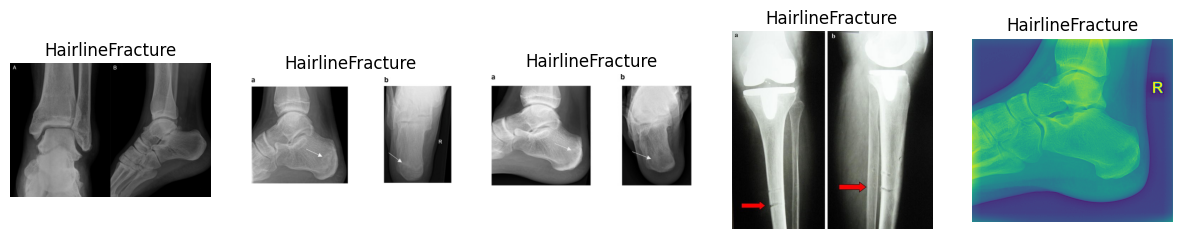

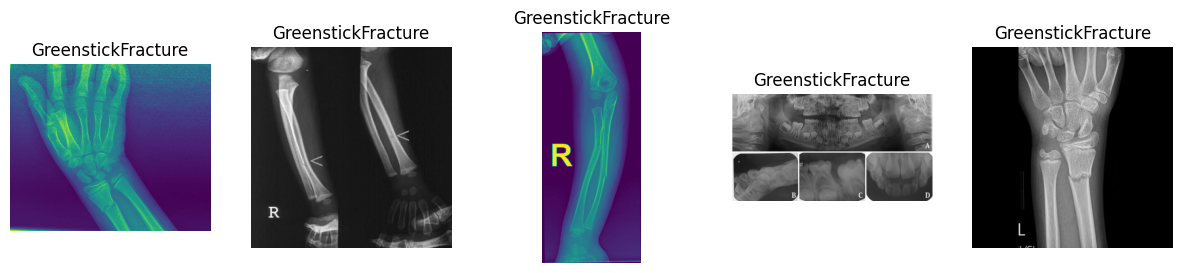

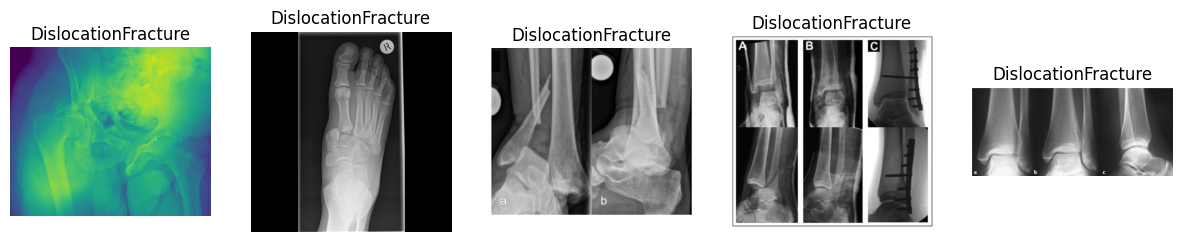

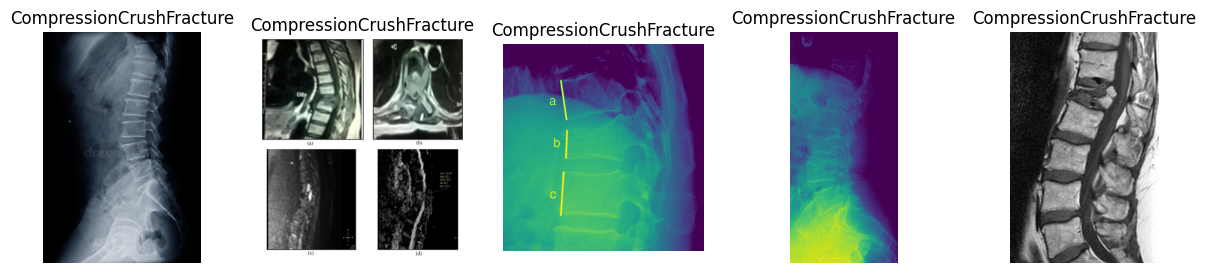

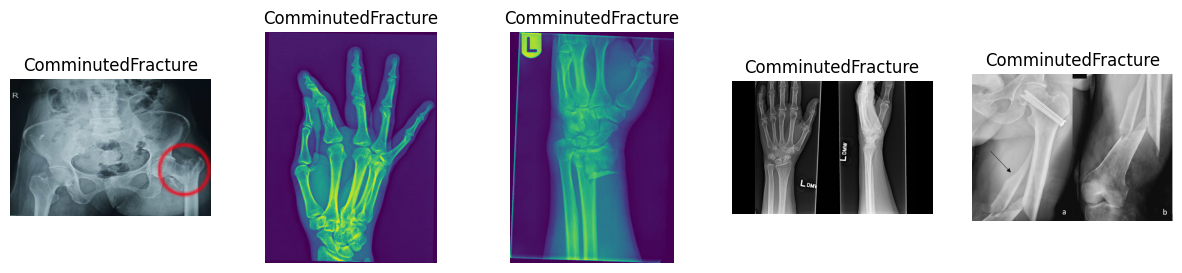

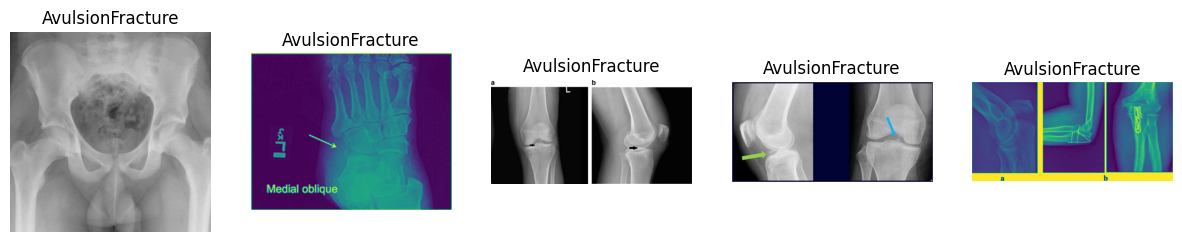

In [59]:
# Display a few images from each class
for class_name, path in cleaned_dataset_paths.items():
    images = os.listdir(path)[:5]  

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, img in enumerate(images):
        image_path = os.path.join(path, img)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].set_title(class_name)
        axs[i].axis('off')
    plt.show()

In [60]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=30),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Load the ImageFolder dataset
dataset = datasets.ImageFolder(root="BoneBreak_Clean/", transform=transform)

# Split the dataset into training and test sets
X = [x[0] for x in dataset.imgs]  # List of file paths
y = [x[1] for x in dataset.imgs]  # List of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create new ImageFolder datasets for training and test sets
train_dataset = datasets.ImageFolder(root="BoneBreak_Clean/", transform=transform)
train_dataset.imgs = [(X_train[i], y_train[i]) for i in range(len(X_train))]

test_dataset = datasets.ImageFolder(root="BoneBreak_Clean/", transform=transform)
test_dataset.imgs = [(X_test[i], y_test[i]) for i in range(len(X_test))]

# Print class names and lengths
class_names = train_dataset.classes
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))
print("Number of Training Samples:", len(train_dataset))
print("Number of Test Samples:", len(test_dataset))

Class Names: ['AvulsionFracture', 'ComminutedFracture', 'CompressionCrushFracture', 'DislocationFracture', 'GreenstickFracture', 'HairlineFracture', 'ImpactedFracture', 'IntraArticularFracture', 'LongitudinalFracture', 'ObliqueFracture', 'PathologicalFracture', 'spiralFracture']
Number of Classes: 12
Number of Training Samples: 1021
Number of Test Samples: 1021


In [61]:
# The model will be trained on a GPU if one with CUDA support is available; otherwise, it will use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a DataLoader with batch size 10 to get 10 random samples
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Load a pre-trained ResNet model
pretrained_resnet = models.resnet18(pretrained=True)

# Modify the last layer for number of classes 
num_classes = 12
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Transfer the model to my device
pretrained_resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.0001)
    

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    # Training
    pretrained_resnet.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_resnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    train_loss = train_loss / len(train_dataloader.dataset)

    # Validation
    pretrained_resnet.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_resnet(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += torch.sum(predicted == labels).item()
            total_predictions += labels.size(0)

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(test_dataloader.dataset)
    accuracy = correct_predictions / total_predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}')

Epoch [1/25], Training Loss: 2.4877, Validation Loss: 2.1903, Accuracy: 0.25
Epoch [2/25], Training Loss: 2.1660, Validation Loss: 1.9995, Accuracy: 0.33
Epoch [3/25], Training Loss: 2.0227, Validation Loss: 1.8751, Accuracy: 0.38
Epoch [4/25], Training Loss: 1.9066, Validation Loss: 1.7996, Accuracy: 0.40
Epoch [5/25], Training Loss: 1.8630, Validation Loss: 1.7369, Accuracy: 0.42
Epoch [6/25], Training Loss: 1.7774, Validation Loss: 1.6231, Accuracy: 0.45
Epoch [7/25], Training Loss: 1.7049, Validation Loss: 1.5672, Accuracy: 0.48
Epoch [8/25], Training Loss: 1.6706, Validation Loss: 1.4890, Accuracy: 0.49
Epoch [9/25], Training Loss: 1.5585, Validation Loss: 1.4804, Accuracy: 0.51
Epoch [10/25], Training Loss: 1.4889, Validation Loss: 1.3536, Accuracy: 0.57
Epoch [11/25], Training Loss: 1.4515, Validation Loss: 1.2877, Accuracy: 0.59
Epoch [12/25], Training Loss: 1.4287, Validation Loss: 1.2252, Accuracy: 0.60
Epoch [13/25], Training Loss: 1.3309, Validation Loss: 1.1415, Accuracy: 